Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Data loaded
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Sequence defined
[[-2.0058984e-05  7.1462935e-05]
 [-1.5478807e-05  2.9428158e-05]
 [-8.8770736e-05  1.9175363e-04]
 ...
 [-4.2159012e-05 -1.2194294e-05]
 [-2.6598855e-05 -5.1154544e-05]
 [-1.0723040e-05 -4.6191377e-05]]
[[-2.0058984e-05  7.1462935e-05]
 [-1.5478807e-05  2.9428158e-05]
 [-8.8770736e-05  1.9175363e-04]
 ...
 [-4.2159012e-05 -1.2194294e-05]
 [-2.6598855e-05 -5.1154544e-05]
 [-1.0723040e-05 -4.6191377e-05]]
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]

[UG] Grid generation:  0.07288360595703125 seconds
[UG] Mem alloc:  0.0004992485046386719 seconds
[UG] Mem copy:  0.0009970664978027344 seconds
[UG] Run:  0.003492593765258789 seconds
[UG] Copy back:  0.009983539581298828 seconds
[UG] Total:  0.11331534385681152 seconds
[UG] neg_f:  0.113 s
Mem alloc:  0.0 seconds
Mem copy:  0.006989002227783203 seconds


c:\Git\hyperbolic-tsne\hyperbolicTSNE\cost_functions_.py:327: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(72): warning #177-D: variable "FLOAT32_TINY" was declared but never referenced
      double FLOAT32_TINY = 1.1754944e-38;
             ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

kernel.cu(74): warning #177-D: variable "qij" was declared but never referenced
      double qij = 0.0;
             ^

kernel.cu(75): warning #177-D: variable "dij" was declared but never referenced
      double dij = 0.0;
             ^

kernel.cu(76): warning #177-D: variable "dij_sq" was declared but never referenced
      double dij_sq = 0.0;
             ^

kernel.cu

  error = gradient(
Gradient Descent error: 2.00000 grad_norm: 8.00000e+02:   0%|          | 1/250 [00:03<14:39,  3.53s/it]

Get func:  3.3078010082244873 seconds
Run:  0.0 seconds
Copy back:  0.0 seconds
[UG] pos_f:  3.317 s
[UG] applying forces:  0.009000000000000001 s
[UG] Grid generation:  0.0509183406829834 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0004990100860595703 seconds
[UG] Run:  0.0004994869232177734 seconds
[UG] Copy back:  0.004492759704589844 seconds
[UG] Total:  0.056409597396850586 seconds
[UG] neg_f:  0.057 s
Mem alloc:  0.0 seconds
Mem copy:  0.0069882869720458984 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.053 s


Gradient Descent error: 2.00000 grad_norm: 8.70276e+06:   1%|          | 3/250 [00:04<03:52,  1.06it/s]

[UG] Grid generation:  0.043430328369140625 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0004990100860595703 seconds
[UG] Run:  0.0004994869232177734 seconds
[UG] Copy back:  0.004991292953491211 seconds
[UG] Total:  0.04991912841796875 seconds
[UG] neg_f:  0.05 s
Mem alloc:  0.0 seconds
Mem copy:  0.0059888362884521484 seconds
Get func:  0.0 seconds
Run:  0.0004994869232177734 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.007 s
[UG] Grid generation:  0.046421051025390625 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0 seconds
[UG] Run:  0.0004994869232177734 seconds
[UG] Copy back:  0.002996206283569336 seconds
[UG] Total:  0.049916744232177734 seconds
[UG] neg_f:  0.05 s
Mem alloc:  0.0 seconds
Mem copy:  0.0069882869720458984 seconds
Get func:  0.0 seconds
Run:  0.0004990100860595703 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.009000000000000001 s
[UG] applying forces:  0.013000000000000001 s


Gradient Descent error: 2.00000 grad_norm: 8.56055e+06:   2%|▏         | 5/250 [00:04<01:54,  2.14it/s]

[UG] Grid generation:  0.04892086982727051 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0010001659393310547 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.004005908966064453 seconds
[UG] Total:  0.05491161346435547 seconds
[UG] neg_f:  0.055 s
Mem alloc:  0.0 seconds
Mem copy:  0.006486654281616211 seconds
Get func:  0.0 seconds
Run:  0.0004885196685791016 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.02 s
[UG] Grid generation:  0.04291796684265137 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0005004405975341797 seconds
[UG] Run:  0.0004990100860595703 seconds
[UG] Copy back:  0.004490375518798828 seconds
[UG] Total:  0.048905134201049805 seconds
[UG] neg_f:  0.049 s
Mem alloc:  0.0 seconds
Mem copy:  0.006490230560302734 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0004985332489013672 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.009000000000000001 s


Gradient Descent error: 2.00000 grad_norm: 8.39278e+06:   3%|▎         | 7/250 [00:04<01:11,  3.42it/s]

[UG] Grid generation:  0.04192018508911133 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0014994144439697266 seconds
[UG] Run:  0.0004963874816894531 seconds
[UG] Copy back:  0.0034940242767333984 seconds
[UG] Total:  0.047410011291503906 seconds
[UG] neg_f:  0.047 s
Mem alloc:  0.0 seconds
Mem copy:  0.006005048751831055 seconds
Get func:  0.0 seconds
Run:  0.0004868507385253906 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.011 s
[UG] Grid generation:  0.05092000961303711 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0004987716674804688 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0029959678649902344 seconds
[UG] Total:  0.05441474914550781 seconds
[UG] neg_f:  0.055 s
Mem alloc:  0.0 seconds
Mem copy:  0.006974935531616211 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0004985332489013672 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.009000000000000001 s


Gradient Descent error: 2.00000 grad_norm: 7.85627e+06:   4%|▎         | 9/250 [00:04<00:52,  4.56it/s]

[UG] Grid generation:  0.041931867599487305 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009834766387939453 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.004508018493652344 seconds
[UG] Total:  0.047907352447509766 seconds
[UG] neg_f:  0.048 s
Mem alloc:  0.0 seconds
Mem copy:  0.0059893131256103516 seconds
Get func:  0.0 seconds
Run:  0.00048470497131347656 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.008 s
[UG] Grid generation:  0.04242992401123047 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009987354278564453 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.004492282867431641 seconds
[UG] Total:  0.04842066764831543 seconds
[UG] neg_f:  0.048 s
Mem alloc:  0.0 seconds
Mem copy:  0.005991935729980469 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.008 s


Gradient Descent error: 2.00000 grad_norm: 7.85627e+06:   4%|▎         | 9/250 [00:05<02:15,  1.78it/s]


4
Running Gradient Descent, Verbosity: True
[gradient_descent] Warning!: because of logging, the cf will be computed at every iteration


Gradient Descent error: 2.00000 grad_norm: 7.91879e+06:   0%|          | 0/750 [00:00<?, ?it/s]

[UG] Grid generation:  0.050917863845825195 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009992122650146484 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0029942989349365234 seconds
[UG] Total:  0.05491137504577637 seconds
[UG] neg_f:  0.055 s
Mem alloc:  0.0 seconds
Mem copy:  0.008987665176391602 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0004968643188476562 seconds
[UG] pos_f:  0.011 s
[UG] applying forces:  0.007 s


Gradient Descent error: 2.00000 grad_norm: 7.91879e+06:   0%|          | 1/750 [00:00<02:32,  4.91it/s]

[UG] Grid generation:  0.04942059516906738 seconds
[UG] Mem alloc:  0.0 seconds


Gradient Descent error: 2.00000 grad_norm: 7.50609e+06:   0%|          | 2/750 [00:00<02:11,  5.67it/s]

[UG] Mem copy:  0.00099945068359375 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.004492521286010742 seconds
[UG] Total:  0.056409597396850586 seconds
[UG] neg_f:  0.056 s
Mem alloc:  0.0 seconds
Mem copy:  0.006490230560302734 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.008 s
[UG] applying forces:  0.008 s
[UG] Grid generation:  0.04241609573364258 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0004994869232177734 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0029973983764648438 seconds
[UG] Total:  0.04641270637512207 seconds
[UG] neg_f:  0.047 s
Mem alloc:  0.0 seconds
Mem copy:  0.006968975067138672 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0005002021789550781 seconds
[UG] pos_f:  0.009000000000000001 s
[UG] applying forces:  0.01 s


Gradient Descent error: 2.00000 grad_norm: 5.98366e+06:   1%|          | 4/750 [00:00<02:14,  5.56it/s]

[UG] Grid generation:  0.056908369064331055 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0004987716674804688 seconds
[UG] Run:  0.0004992485046386719 seconds
[UG] Copy back:  0.001996755599975586 seconds
[UG] Total:  0.05990314483642578 seconds
[UG] neg_f:  0.06 s
Mem alloc:  0.0 seconds
Mem copy:  0.006989240646362305 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0 seconds
[UG] pos_f:  0.009000000000000001 s
[UG] applying forces:  0.007 s
[UG] Grid generation:  0.040924787521362305 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.001005411148071289 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.009477376937866211 seconds
[UG] Total:  0.051407575607299805 seconds
[UG] neg_f:  0.052000000000000005 s
Mem alloc:  0.0 seconds
Mem copy:  0.012477874755859375 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0004992485046386719 seconds
[UG] pos_f:  0.014 s
[UG] applying forces:  0.008 s


Gradient Descent error: 2.00000 grad_norm: 6.13376e+06:   1%|          | 6/750 [00:01<02:08,  5.77it/s]

[UG] Grid generation:  0.042931556701660156 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0019965171813964844 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0034942626953125 seconds
[UG] Total:  0.04842233657836914 seconds
[UG] neg_f:  0.048 s
Mem alloc:  0.0 seconds
Mem copy:  0.00998544692993164 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.002012968063354492 seconds
[UG] pos_f:  0.014 s
[UG] applying forces:  0.008 s
[UG] Grid generation:  0.04243206977844238 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009984970092773438 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0029954910278320312 seconds
[UG] Total:  0.04692506790161133 seconds
[UG] neg_f:  0.046 s
Mem alloc:  0.0 seconds
Mem copy:  0.008476734161376953 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.000499725341796875 seconds
[UG] pos_f:  0.011 s
[UG] applying forces:  0.007 s


Gradient Descent error: 2.00000 grad_norm: 6.76335e+06:   1%|          | 8/750 [00:01<02:01,  6.12it/s]

[UG] Grid generation:  0.04243278503417969 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009989738464355469 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.0029952526092529297 seconds
[UG] Total:  0.046427011489868164 seconds
[UG] neg_f:  0.046 s
Mem alloc:  0.0 seconds
Mem copy:  0.009967327117919922 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0005092620849609375 seconds
[UG] pos_f:  0.012 s
[UG] applying forces:  0.008 s
[UG] Grid generation:  0.04143691062927246 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0005023479461669922 seconds
[UG] Run:  0.0 seconds
[UG] Copy back:  0.002996683120727539 seconds
[UG] Total:  0.045435190200805664 seconds
[UG] neg_f:  0.046 s
Mem alloc:  0.0 seconds
Mem copy:  0.011467933654785156 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.0004994869232177734 seconds
[UG] pos_f:  0.013000000000000001 s
[UG] applying forces:  0.016 s


Gradient Descent error: 2.00000 grad_norm: 4.44193e+06:   1%|          | 9/750 [00:01<02:21,  5.24it/s]


[UG] Grid generation:  0.05740833282470703 seconds
[UG] Mem alloc:  0.0 seconds
[UG] Mem copy:  0.0009996891021728516 seconds
[UG] Run:  0.0004985332489013672 seconds
[UG] Copy back:  0.002496004104614258 seconds
[UG] Total:  0.06140255928039551 seconds
[UG] neg_f:  0.061 s
Mem alloc:  0.0 seconds
Mem copy:  0.01048421859741211 seconds
Get func:  0.0 seconds
Run:  0.0 seconds
Copy back:  0.001497030258178711 seconds
[UG] pos_f:  0.014 s
[UG] applying forces:  0.007 s
4
Execution time: 6.9484703540802 seconds


C:\Users\Milan\AppData\Local\Temp\ipykernel_24028\3829761342.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Sequence defined
would run exact
Execution time: 0.0 seconds


C:\Users\Milan\AppData\Local\Temp\ipykernel_24028\3829761342.py:225: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


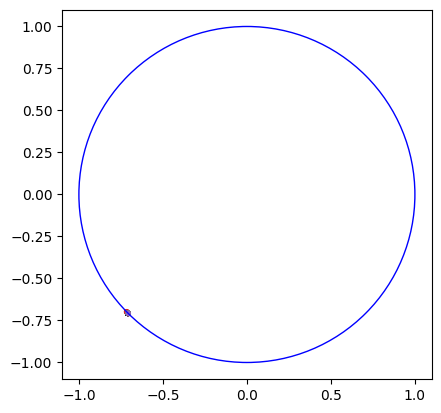

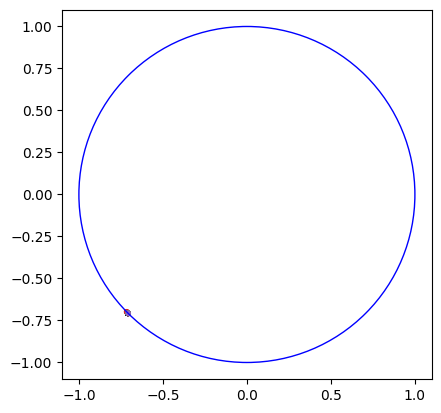

In [1]:
import os
import traceback
import numpy as np
import time
#from cuda import cuda, nvrtc

from hyperbolicTSNE.util import find_last_embedding
from hyperbolicTSNE.visualization import plot_poincare, animate
from hyperbolicTSNE import load_data, Datasets, SequentialOptimizer, initialization, HyperbolicTSNE

data_home = "datasets"
log_path = "temp/poincaregpu/"  # path for saving embedding snapshots

only_animate = False
seed = 42
dataset = Datasets.PLANARIA  # the Datasets handler provides access to several data sets used throughout the repository
num_points = 20000  # we use a subset for demonstration purposes, full MNIST has N=70000
perp = 15  # we use a perplexity of 30 in this example

dataX, dataLabels, D, V, _ = load_data(
    dataset, 
    data_home=data_home, 
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_points, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)

print("Data loaded")

exaggeration_factor = 12  # Just like regular t-SNE, we use early exaggeration with a factor of 12
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)  # We adjust the learning rate to the hyperbolic setting
ex_iterations = 250  # The embedder is to execute 250 iterations of early exaggeration, ...
main_iterations = 750  # ... followed by 750 iterations of non-exaggerated gradient descent.












# ============= RUNNING EXACT GPU =============







opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=False,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)
print(X_embedded)

start_time = time.time()

try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-inexact.png")









# ============= RUNNING EXACT CPU =============






opt_config = dict(
    learning_rate_ex=learning_rate,  # learning rate during exaggeration
    learning_rate_main=learning_rate,  # learning rate main optimization 
    exaggeration=exaggeration_factor, 
    exaggeration_its=ex_iterations, 
    gradientDescent_its=main_iterations, 
    vanilla=False,  # if vanilla is set to true, regular gradient descent without any modifications is performed; for  vanilla set to false, the optimization makes use of momentum and gains
    momentum_ex=0.5,  # Set momentum during early exaggeration to 0.5
    momentum=0.8,  # Set momentum during non-exaggerated gradient descent to 0.8
    exact=True,  # To use the quad tree for acceleration (like Barnes-Hut in the Euclidean setting) or to evaluate the gradient exactly
    area_split=False,  # To build or not build the polar quad tree based on equal area splitting or - alternatively - on equal length splitting
    n_iter_check=10,  # Needed for early stopping criterion
    size_tol=0.999  # Size of the embedding to be used as early stopping criterion
)

opt_params = SequentialOptimizer.sequence_poincare(**opt_config)

print("Sequence defined")

log_path = "temp/poincarecpu/"  # path for saving embedding snapshots

# Start: configure logging
logging_dict = {
    "log_path": log_path
}
opt_params["logging_dict"] = logging_dict

log_path = opt_params["logging_dict"]["log_path"]
# Delete old log path
if os.path.exists(log_path) and not only_animate:
    import shutil
    shutil.rmtree(log_path)
# End: logging

# Compute an initial embedding of the data via PCA
X_embedded = initialization(
    n_samples=dataX.shape[0],
    n_components=2,
    X=dataX,
    random_state=seed,
    method="pca"
)

# Initialize the embedder
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed", 
    verbose=True, 
    opt_method=SequentialOptimizer, 
    opt_params=opt_params
)

start_time = time.time()

try:
    #hyperbolicEmbedding = htsne.fit_transform((D, V))
    print("would run exact")
except ValueError:
    print("Error!")
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

# Create a rendering of the embedding and save it to a file
if not os.path.exists("results"):
    os.mkdir("results")
fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.show()
fig.savefig(f"results/{dataset.name}-exact.png")